In [ ]:
import pandas as pd
import pickle
from mpl_finance import candlestick2_ohlc
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

In [5]:
with open('../data/benchmark_data.pkl', 'rb') as handle:
    bm = pickle.load(handle)
ibex = bm['ibex']

db_dataset = pd.read_csv("../data/doble_suelo_balanceado.csv")
db_dataset["date"] = pd.to_datetime(db_dataset["date"], format="%Y-%m-%d").to_frame()

window = 30

### Visualizar los datos

##### Positive OHLC

In [ ]:
class_0 = db_dataset[db_dataset["class"] == 0]
class_1 = db_dataset[db_dataset["class"] == 1]

for data in class_1.iterrows():
    windata = ibex.loc[data[1].date:].head(window)

    fig, ax = plt.subplots(figsize=(6, 4))
    candlestick2_ohlc(ax, windata.open, windata.high,
                      windata.low, windata.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)
    print(data[1].date)
    plt.show()


##### Negative OHLC

In [ ]:
for data in class_0[10:12].iterrows():
    windata = ibex.loc[data[1].date:].head(window)

    fig, ax = plt.subplots(figsize=(6, 4))
    candlestick2_ohlc(ax, windata.open, windata.high,
                      windata.low, windata.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)
    print(data[1].date)
    plt.show()

In [ ]:
class_0 = db_dataset[db_dataset["class"] == 0]
class_1 = db_dataset[db_dataset["class"] == 1]

n_min = 4
n_max = 1

for data in class_0.iterrows():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    windata = ibex.loc[data[1].date:].head(window)

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]

    candlestick2_ohlc(ax1, windata.open, windata.high,

                      windata.low, windata.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)

    ax2 = plt.scatter(local_min.index, local_min.low, c='r')
    ax2 = plt.scatter(local_max.index, local_max.low, c='g')
    ax2 = plt.plot(windata["low"].index, windata["low"].values)

    print(data[1].date)

    plt.show()


In [ ]:
class_0 = db_dataset[db_dataset["class"] == 0]
class_1 = db_dataset[db_dataset["class"] == 1]

n_min = 4
n_max = 1

for data in class_1.iterrows():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    windata = ibex.loc[data[1].date:].head(window)

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]
    local_max = lmax.to_frame()

    candlestick2_ohlc(ax1, windata.open, windata.high,

                      windata.low, windata.close,
                      colorup='g', colordown='r', width=0.66, alpha=0.8)

    ax2 = plt.scatter(local_min.index, local_min.low, c='r')
    ax2 = plt.scatter(local_max.index, local_max.low, c='g')
    ax2 = plt.plot(windata["low"].index, windata["low"].values)

    print(data[1].date)

    plt.show()


In [7]:
datos_etiquetados = pd.DataFrame(
    columns=["is_min_before_max", "dias_entre_minimos", "distancia_precio_minimos", "retorno",
             "distancia_primer_dia_minimo_local", "n_local_max", "diferencia_precio", "class"])

,is_min_before_max,dias_entre_minimos,distancia_precio_minimos,retorno,distancia_primer_dia_minimo_local,n_local_max,diferencia_precio,class


In [8]:
def etiquetado_datos(window_df: pd.DataFrame):
    lows = window_df.iloc[argrelextrema(window_df.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    lclose = window_df.iloc[argrelextrema(window_df.close.values, np.greater_equal, order=n_min)[0]]["close"]

    # Si ocurren antes el minimo o el maximo
    is_min_before_max = int(
        window_df.iloc[np.argmin(window_df["low"])].name < window_df.iloc[np.argmax(window_df["low"])].name)

    # distancia entre los dos minimos en días
    local_min = lows.to_frame().sort_values(by="low")[:2]

    if len(local_min) == 2:
        dias_entre_minimos = abs((local_min.iloc[0].name - local_min.iloc[1].name).days)
    else:
        dias_entre_minimos = -1

    # distancia entre los dos minimos en precio
    if len(local_min) == 2:
        distancia_precio_minimos = round(abs(local_min.iloc[0].low - local_min.iloc[1].low), 2)
    else:
        distancia_precio_minimos = -1

    # retorno de la ventana
    retorno = round(np.sum(np.log(windata["close"]).diff()), 4)

    # distancia de la primera vela al primer minimo
    if len(local_min) == 2:
        dt_ordered_local_min = local_min.sort_index()
        primer_dia_ventana = windata.iloc[0].name
        dia_primer_minimo = dt_ordered_local_min.iloc[0].name
        distancia_primer_dia_minimo_local = abs((primer_dia_ventana - dia_primer_minimo).days)
        if distancia_primer_dia_minimo_local == 0:
            distancia_primer_dia_minimo_local = -1
    else:
        distancia_primer_dia_minimo_local = -1

    # numero de maximos locales entre dos minimos
    if len(local_min) == 2:
        dt_ordered_local_min = local_min.sort_index()
        l_max = (lmax.to_frame().index > dt_ordered_local_min.iloc[0].name) * (
                lmax.to_frame().index < dt_ordered_local_min.iloc[1].name)
        n_local_max = len(lmax[l_max])
    else:
        n_local_max = -1

    # diferencia entre el cierre del maximo local entre dos minimos y el maximo después del segundo minimo local
    if len(local_min) == 2:
        dt_ordered_local_min = local_min.sort_index()
        l_max = (lmax.to_frame().index > dt_ordered_local_min.iloc[0].name) * (
                lmax.to_frame().index < dt_ordered_local_min.iloc[1].name)
        precio_maximo_local = lmax[l_max].max()
        precio_maximo_final = windata[dt_ordered_local_min.iloc[1].name:].close.max()
        diferencia_precio = round(precio_maximo_final - precio_maximo_local, 4)
    else:
        diferencia_precio = 0

    return is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio



In [9]:
n_min = 4
n_max = 1

for data in class_0.iterrows():
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    windata = ibex.loc[data[1].date:].head(window)

    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio = etiquetado_datos(
        windata.copy())

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]
    local_max = lmax.to_frame()

    # candlestick2_ohlc(ax1, windata.open, windata.high,
    #
    #                   windata.low, windata.close,
    #                   colorup='g', colordown='r', width=0.66, alpha=0.8)
    #
    # ax2 = plt.scatter(local_min.index, local_min.low, c='r')
    # ax2 = plt.scatter(local_max.index, local_max.low, c='g')
    # ax2 = plt.plot(windata["low"].index, windata["low"].values)

    #print("##################################################################################################")
    #print(data[1].date)
    #print("--------------")
    #print(f"Ocurre el minimo antes que el máximo: {is_min_before_max}")
    #print(f"Distancia entre los dos minimos en días: {dias_entre_minimos}")
    #print(f"Distancia entre los dos minimos en precio: {distancia_precio_minimos}")
    #print(f"Retorno de la ventana: {retorno}")
    #print(f"Distancia de la primera vela al primer minimo: {distancia_primer_dia_minimo_local}")
    #print(f"Numero de maximos locales entre dos minimos: {n_local_max}")
    #print(f"Diferencia al punto de ruptura: {diferencia_precio}")
    #print("##################################################################################################")
    #plt.show()

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "class": 0
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)

/tmp/ipykernel_4069/478762673.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_4069/478762673.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_4069/478762673.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_4069/478762673.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp

In [10]:
n_min = 4
n_max = 1

for data in class_1.iterrows():
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

    windata = ibex.loc[data[1].date:].head(window)

    is_min_before_max, dias_entre_minimos, distancia_precio_minimos, retorno, distancia_primer_dia_minimo_local, n_local_max, diferencia_precio = etiquetado_datos(
        windata.copy())

    lows = windata.iloc[argrelextrema(windata.low.values, np.less_equal, order=n_min)[0]]["low"]
    lmax = windata.iloc[argrelextrema(windata.low.values, np.greater_equal, order=n_max)[0]]["low"]

    local_min = lows.to_frame().sort_values(by="low")[:2]
    local_max = lmax.to_frame().sort_values(by="low", ascending=False)[:2]
    local_max = lmax.to_frame()

    # candlestick2_ohlc(ax1, windata.open, windata.high,
    #
    #                   windata.low, windata.close,
    #                   colorup='g', colordown='r', width=0.66, alpha=0.8)
    #
    # ax2 = plt.scatter(local_min.index, local_min.low, c='r')
    # ax2 = plt.scatter(local_max.index, local_max.low, c='g')
    # ax2 = plt.plot(windata["low"].index, windata["low"].values)

    #print("##################################################################################################")
    #print(data[1].date)
    #print("--------------")
    #print(f"Ocurre el minimo antes que el máximo: {is_min_before_max}")
    #print(f"Distancia entre los dos minimos en días: {dias_entre_minimos}")
    #print(f"Distancia entre los dos minimos en precio: {distancia_precio_minimos}")
    #print(f"Retorno de la ventana: {retorno}")
    #print(f"Distancia de la primera vela al primer minimo: {distancia_primer_dia_minimo_local}")
    #print(f"Numero de maximos locales entre dos minimos: {n_local_max}")
    #print(f"Diferencia al punto de ruptura: {diferencia_precio}")
    #print("##################################################################################################")
    #plt.show()

    labeled_obs = {
        "is_min_before_max": is_min_before_max,
        "dias_entre_minimos": dias_entre_minimos,
        "distancia_precio_minimos": distancia_precio_minimos,
        "retorno": retorno,
        "distancia_primer_dia_minimo_local": distancia_primer_dia_minimo_local,
        "n_local_max": n_local_max,
        "diferencia_precio": diferencia_precio,
        "class": 1
    }

    datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)


/tmp/ipykernel_4069/1333272169.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_4069/1333272169.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_4069/1333272169.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)
/tmp/ipykernel_4069/1333272169.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datos_etiquetados = datos_etiquetados.append(labeled_obs, ignore_index=True)


In [11]:
datos_etiquetados

,is_min_before_max,dias_entre_minimos,distancia_precio_minimos,retorno,distancia_primer_dia_minimo_local,n_local_max,diferencia_precio,class
0,0.0,14.0,248.5,-0.1632,26.0,3.0,-503.5,0.0
1,1.0,41.0,595.4,0.0524,-1.0,7.0,-117.4,0.0
2,1.0,16.0,42.4,0.0179,5.0,2.0,88.6,0.0
3,0.0,17.0,11.1,-0.0721,24.0,3.0,-203.3,0.0
4,1.0,28.0,483.4,0.0618,6.0,4.0,59.2,0.0
...,...,...,...,...,...,...,...,...
161,0.0,12.0,27.5,-0.0197,21.0,1.0,387.8,1.0
162,1.0,20.0,43.8,0.1266,4.0,3.0,1081.9,1.0
163,1.0,15.0,26.6,0.1484,-1.0,3.0,795.5,1.0
164,1.0,16.0,26.7,0.0342,-1.0,2.0,259.7,1.0


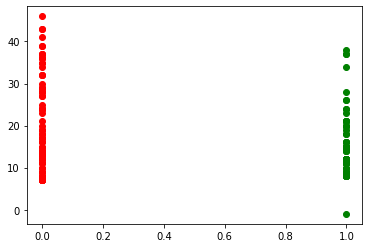

In [13]:
import matplotlib.pyplot as plt

plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 0]["class"],datos_etiquetados[datos_etiquetados["class"] == 0]["dias_entre_minimos"] , c='r')
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 1]["class"],datos_etiquetados[datos_etiquetados["class"] == 1]["dias_entre_minimos"], c='g')
plt.show()

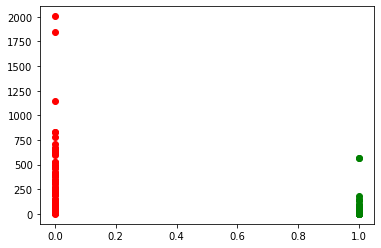

In [14]:
import matplotlib.pyplot as plt
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 0]["class"],datos_etiquetados[datos_etiquetados["class"] == 0]["distancia_precio_minimos"] , c='r')
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 1]["class"],datos_etiquetados[datos_etiquetados["class"] == 1]["distancia_precio_minimos"], c='g')
plt.show()

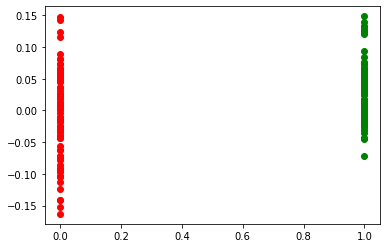

In [15]:
plt.show()
import matplotlib.pyplot as plt

plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 0]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 0]["retorno"], c='r')
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 1]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 1]["retorno"], c='g')
plt.show()

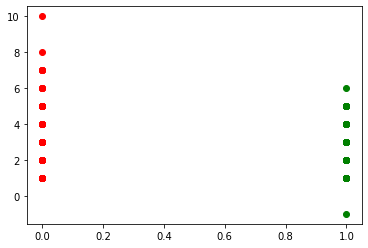

In [16]:
plt.show()
import matplotlib.pyplot as plt

plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 0]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 0]["n_local_max"], c='r')
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 1]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 1]["n_local_max"], c='g')
plt.show()

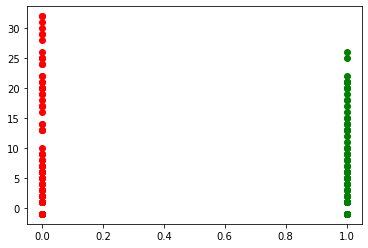

In [17]:
plt.show()
import matplotlib.pyplot as plt

plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 0]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 0]["distancia_primer_dia_minimo_local"], c='r')
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 1]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 1]["distancia_primer_dia_minimo_local"], c='g')
plt.show()

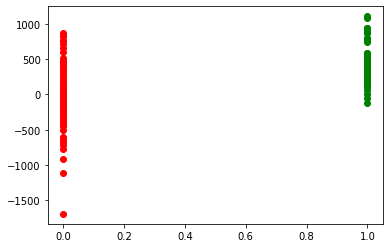

In [19]:
plt.show()
plt.show()
import matplotlib.pyplot as plt

plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 0]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 0]["diferencia_precio"], c='r')
plt.scatter(datos_etiquetados[datos_etiquetados["class"] == 1]["class"],
            datos_etiquetados[datos_etiquetados["class"] == 1]["diferencia_precio"], c='g')
plt.show()

In [20]:
datos_etiquetados[datos_etiquetados["class"] == 0]["diferencia_precio"].value_counts()

 453.3     3
-503.5     1
 446.0     1
-323.4     1
-1692.6    1
          ..
 107.4     1
 347.5     1
-411.4     1
-108.6     1
 227.1     1
Name: diferencia_precio, Length: 81, dtype: int64

In [22]:
features = datos_etiquetados.loc[:,:"diferencia_precio"]
target = datos_etiquetados["class"]
features

,is_min_before_max,dias_entre_minimos,distancia_precio_minimos,retorno,distancia_primer_dia_minimo_local,n_local_max,diferencia_precio
0,0.0,14.0,248.5,-0.1632,26.0,3.0,-503.5
1,1.0,41.0,595.4,0.0524,-1.0,7.0,-117.4
2,1.0,16.0,42.4,0.0179,5.0,2.0,88.6
3,0.0,17.0,11.1,-0.0721,24.0,3.0,-203.3
4,1.0,28.0,483.4,0.0618,6.0,4.0,59.2
...,...,...,...,...,...,...,...
161,0.0,12.0,27.5,-0.0197,21.0,1.0,387.8
162,1.0,20.0,43.8,0.1266,4.0,3.0,1081.9
163,1.0,15.0,26.6,0.1484,-1.0,3.0,795.5
164,1.0,16.0,26.7,0.0342,-1.0,2.0,259.7


In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

ft_norm_arr = MinMaxScaler().fit_transform(features)
ft_norm = pd.DataFrame(ft_norm_arr, columns=features.columns)

In [24]:
train_x, test_x, train_y, test_y = train_test_split(ft_norm.values,
                                                    target.values,
                                                    test_size=0.8,
                                                    stratify=target.values,
                                                    random_state=11
                                                    )

In [25]:
tree = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier()

In [26]:
single_tree = DecisionTreeClassifier().fit(train_x, train_y)
y_pred_single = single_tree.predict(test_x)

In [27]:
print("Tree:", accuracy_score(test_y, y_pred_single))

Tree: 0.8872180451127819


In [29]:
from sklearn.metrics import f1_score
f1_score(test_y, y_pred_single, average=None)

array([0.8951049 , 0.87804878])

In [31]:
from sklearn.metrics import classification_report
print(classification_report(test_y, y_pred_single, target_names=["No dobre suelo","Doble suelo"]))

                precision    recall  f1-score   support

No dobre suelo       0.83      0.97      0.90        66
   Doble suelo       0.96      0.81      0.88        67

      accuracy                           0.89       133
     macro avg       0.90      0.89      0.89       133
  weighted avg       0.90      0.89      0.89       133



Curva ROC

In [32]:
from sklearn.metrics import roc_curve
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

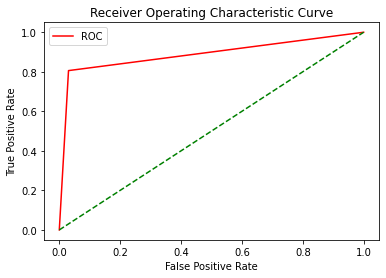

In [33]:
fper, tper, thresholds = roc_curve(test_y, y_pred_single)
plot_roc_curve(fper, tper)

In [34]:
from sklearn import metrics
metrics.auc(fper, tper)

0.8878335594753506

#### Iteración 2